<a href="https://colab.research.google.com/github/yogitaaax22/eeg_website/blob/main/notebooks/google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [484]:
# Core
import numpy as np
import pandas as pd
import os
import zipfile

# EEG / Signal processing
from scipy.io import loadmat
from scipy.signal import welch

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("All libraries imported successfully")


All libraries imported successfully


In [485]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [486]:
#Unzip the file
import zipfile

zip_path = '/content/drive/MyDrive/EEG_480_signals.zip'
extract_dir = '/content/eeg_files'

# Extract only once
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("All files extracted to:", extract_dir)


All files extracted to: /content/eeg_files


In [487]:
mat_files = []

for root, dirs, files in os.walk("eeg_data"):
    for file in files:
        if file.endswith(".mat"):
            mat_files.append(os.path.join(root, file))

print("Total EEG files found:", len(mat_files))
print("Example files:", mat_files[:3])


Total EEG files found: 0
Example files: []


In [488]:
import os

DATA_PATH = "eeg_files/raw_data"

mat_files = []
for file in os.listdir(DATA_PATH):
    if file.endswith(".mat"):
        mat_files.append(os.path.join(DATA_PATH, file))

print("Total .mat files found:", len(mat_files))
print("First 5 files:", mat_files[:5])





Total .mat files found: 480
First 5 files: ['eeg_files/raw_data/Arithmetic_sub_6_trial2.mat', 'eeg_files/raw_data/Arithmetic_sub_6_trial3.mat', 'eeg_files/raw_data/Stroop_sub_22_trial3.mat', 'eeg_files/raw_data/Relax_sub_13_trial2.mat', 'eeg_files/raw_data/Arithmetic_sub_27_trial3.mat']


In [489]:
from scipy.io import loadmat

sample = loadmat(mat_files[0])
print(sample.keys())


dict_keys(['__header__', '__version__', '__globals__', 'Data'])


In [490]:
EEG_KEY = 'Data'   # <-- replace this

eeg = sample[EEG_KEY]
print("Original EEG shape:", eeg.shape)


Original EEG shape: (32, 3200)


Single-channel EEG shape: (3200,)


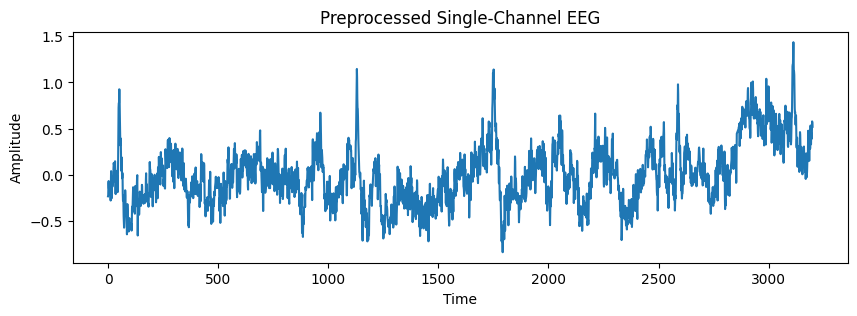

In [491]:
# Ensure shape is (time, channels)
if eeg.shape[0] < eeg.shape[1]:
    eeg = eeg.T

# Normalize
eeg = (eeg - np.mean(eeg)) / np.std(eeg)

# Convert to single channel
eeg_1ch = np.mean(eeg, axis=1)

print("Single-channel EEG shape:", eeg_1ch.shape)

# Plot to verify
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(eeg_1ch)
plt.title("Preprocessed Single-Channel EEG")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


In [492]:
def extract_band_power(signal, fs=128):
    freqs, psd = welch(signal, fs=fs, nperseg=fs*2)
    bands = {'low': (0.5, 8), 'alpha': (8, 13), 'beta': (13, 30)}

    powers = []
    for band in bands.values():
        idx = (freqs >= band[0]) & (freqs <= band[1])
        powers.append(np.mean(psd[idx]))

    total = sum(powers) + 1e-6
    return [p / total for p in powers]

In [493]:
from scipy.stats import skew, kurtosis, mstats

X = []
y = []

for file_path in mat_files:
    mat = loadmat(file_path)
    eeg = mat['Data']
    if eeg.shape[0] < eeg.shape[1]: eeg = eeg.T

    # --- NEW: Clip Outliers (Winsorize) ---
    # This keeps 95% of the data but pulls in the extreme 'noise' spikes
    eeg = mstats.winsorize(eeg, limits=[0.05, 0.05], axis=0)

    eeg = (eeg - np.mean(eeg, axis=0)) / (np.std(eeg, axis=0) + 1e-6)

    all_channel_features = []
    for ch in range(eeg.shape[1]):
        sig = eeg[:, ch]
        rel_p = extract_band_power(sig)
        all_channel_features.append(rel_p + [skew(sig), kurtosis(sig)])

    ch_feats = np.array(all_channel_features)

    # We only use Frontal and Back averages (Simpler is better!)
    front = ch_feats[:16].mean(axis=0)
    back = ch_feats[16:].mean(axis=0)

    X.append(np.concatenate([front, back])) # 10 features total
    y.append(0 if 'relax' in file_path.lower() else 1)

X = np.array(X)
y = np.array(y)

In [494]:
X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)



Feature matrix shape: (480, 10)
Labels shape: (480,)


In [495]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# ---- REAL BASELINE: mean of all Relax samples in training set ----
baseline = np.mean(X_train[y_train == 0], axis=0)


print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 384
Testing samples: 96


In [496]:
from xgboost import XGBClassifier

# We reset the threshold logic and let the model handle weights internally
model = XGBClassifier(
    n_estimators=100,       # Fewer trees to prevent overfitting
    max_depth=3,            # Very shallow trees
    learning_rate=0.05,
    scale_pos_weight=3,      # Exactly matches your 3:1 data ratio
    subsample=0.8,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
print("Golden XGBoost Trained")

Golden XGBoost Trained


In [522]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# 1. Get the raw probabilities instead of hard labels
# This tells us HOW SURE the model is (e.g., 0.6 stress, 0.4 relax)
probs = model.predict_proba(X_test)[:, 1]

# 2. We will try a "Relax-Friendly" threshold.
# The default is 0.5. By lowering it to 0.4, we tell the model:
# "If you have even a 40% doubt it's Stress, call it Relax."
threshold = 0.6
y_pred_recall_fix = (probs > threshold).astype(int)

print(f"--- Results with Threshold {threshold} ---")
print(f"New Accuracy: {accuracy_score(y_test, y_pred_recall_fix)}")
print(classification_report(y_test, y_pred_recall_fix))

--- Results with Threshold 0.6 ---
New Accuracy: 0.8229166666666666
              precision    recall  f1-score   support

           0       0.89      0.33      0.48        24
           1       0.82      0.99      0.89        72

    accuracy                           0.82        96
   macro avg       0.85      0.66      0.69        96
weighted avg       0.83      0.82      0.79        96



In [498]:
# import pickle

# # Save trained model
# with open("stress_model.pkl", "wb") as f:
#     pickle.dump(model, f)

# # Save baseline (mean of relax samples in training set)
# baseline = X_train[y_train == 0].mean(axis=0)
# with open("baseline.pkl", "wb") as f:
#     pickle.dump(baseline, f)
# #
# print("Model and baseline saved successfully!")


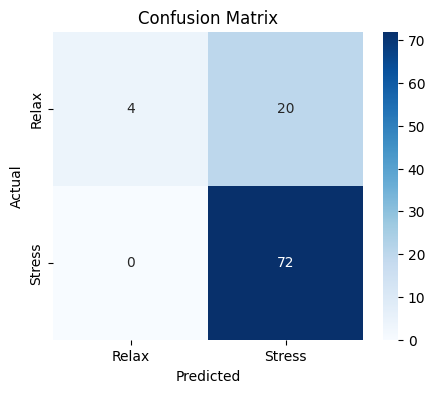

In [524]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Relax', 'Stress'],
            yticklabels=['Relax', 'Stress'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [500]:
# # Use X_test (already created)
# alpha = X_test[:, 2]   # index 2 = alpha
# beta  = X_test[:, 3]   # index 3 = beta

# stress_ratio = beta / (alpha + 1e-6)


In [501]:
# stress_levels = []

# for i in range(len(y_test)):
#     if y_pred[i] == 0:
#         stress_levels.append(0)   # Relax
#     else:
#         if stress_ratio[i] < np.percentile(stress_ratio, 33):
#             stress_levels.append(1)  # Low Stress
#         elif stress_ratio[i] < np.percentile(stress_ratio, 66):
#             stress_levels.append(2)  # Moderate Stress
#         else:
#             stress_levels.append(3)  # High Stress


In [523]:
# import matplotlib.pyplot as plt
# from collections import Counter

# counts = Counter(stress_levels)
# total = sum(counts.values())

# labels = ["Relax", "Low Stress", "Moderate Stress", "High Stress"]
# colors = ["green", "lightgreen", "orange", "red"]

# percentages = [(counts.get(i, 0) / total) * 100 for i in range(4)]
# sample_counts = [counts.get(i, 0) for i in range(4)]

# plt.figure(figsize=(7,5))
# bars = plt.bar(labels, percentages, color=colors)

# plt.ylabel("Percentage of Samples (%)")
# plt.title("Stress Severity Distribution (Test Set)")
# plt.ylim(0, 100)

# # Annotate bars with sample counts
# for bar, count in zip(bars, sample_counts):
#     height = bar.get_height()
#     plt.text(
#         bar.get_x() + bar.get_width()/2,
#         height + 1,
#         f"n={count}",
#         ha='center',
#         va='bottom',
#         fontsize=10
#     )

# plt.show()


ZeroDivisionError: division by zero

In [503]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_score

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

# print("CV Accuracy:", scores.mean(), "±", scores.std())


In [504]:
# !ls


In [505]:
# # -----------------------------
# # Imports
# # -----------------------------
# import os
# import numpy as np
# from scipy.io import loadmat
# from scipy.signal import welch
# import pickle
# from collections import Counter
# import matplotlib.pyplot as plt

# # -----------------------------
# # Load trained model & baseline
# # -----------------------------
# with open("stress_model.pkl", "rb") as f:
#     model = pickle.load(f)

# with open("baseline.pkl", "rb") as f:
#     baseline = pickle.load(f)  # 8 features

# # -----------------------------
# # Feature extraction
# # -----------------------------
# def extract_band_power(signal, fs=128):
#     freqs, psd = welch(signal, fs=fs)
#     bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}
#     features = []
#     for band in bands.values():
#         idx = (freqs >= band[0]) & (freqs <= band[1])
#         features.append(np.mean(psd[idx]))
#     return features  # 4 features per channel

# def extract_features(eeg):
#     # Ensure shape (time, channels)
#     if eeg.shape[0] < eeg.shape[1]:
#         eeg = eeg.T

#     # Normalize per channel
#     eeg = (eeg - np.mean(eeg, axis=0)) / np.std(eeg, axis=0)

#     channel_features = []
#     for ch in range(eeg.shape[1]):
#         band_feats = extract_band_power(eeg[:, ch])
#         channel_features.append(band_feats)

#     channel_features = np.array(channel_features)  # (channels, 4)
#     # Aggregate mean + std across channels
#     mean_feats = channel_features.mean(axis=0)
#     std_feats  = channel_features.std(axis=0)
#     final_features = np.concatenate([mean_feats, std_feats])  # 8 features
#     return final_features

# # -----------------------------
# # Compute multi-level stress
# # -----------------------------
# def compute_stress_level(features, baseline):
#     # Predict binary: 0=Relax, 1=Stress
#     pred_binary = model.predict([features])[0]

#     if pred_binary == 0:
#         return 0  # Relax

#     # Deviation from baseline for alpha & beta bands
#     alpha_idx = 2
#     beta_idx  = 3
#     alpha_dev = abs(features[alpha_idx] - baseline[alpha_idx])
#     beta_dev  = abs(features[beta_idx]  - baseline[beta_idx])
#     stress_index = (alpha_dev + beta_dev) / 2

#     # Thresholds
#     if stress_index < 0.01:
#         return 1  # Low
#     elif stress_index < 0.02:
#         return 2  # Moderate
#     else:
#         return 3  # High

# # -----------------------------
# # Subject file collection
# # -----------------------------
# subject_id = "sub_1"  # change this to the subject you want
# subject_folder = "/content/eeg_files/raw_data"

# # Automatically collect all files for that subject
# subject_files = [
#     os.path.join(subject_folder, f)
#     for f in os.listdir(subject_folder)
#     if subject_id in f.lower() and f.endswith(".mat")
# ]

# print(f"Found {len(subject_files)} files for {subject_id}")
# for f in subject_files:
#     print(f)

# # -----------------------------
# # Process each file
# # -----------------------------
# stress_levels = []
# tasks = []

# for file_path in subject_files:
#     mat = loadmat(file_path)
#     eeg = mat["Data"]

#     features = extract_features(eeg)
#     level = compute_stress_level(features, baseline)

#     # Get task name from filename (Relax, Arithmetic, Mirror, Stroop)
#     task_name = os.path.basename(file_path).split("_")[0].capitalize()

#     stress_levels.append(level)
#     tasks.append(task_name)

# # -----------------------------
# # Visualize
# # -----------------------------
# labels = ["Relax", "Low Stress", "Moderate Stress", "High Stress"]
# colors = ["green", "lightgreen", "orange", "red"]

# counts = Counter(stress_levels)
# sample_counts = [counts.get(i, 0) for i in range(4)]

# plt.figure(figsize=(8,5))
# bars = plt.bar(labels, sample_counts, color=colors)
# plt.ylabel("Number of Files")
# plt.title(f"Stress Levels for {subject_id}")

# for bar, count in zip(bars, sample_counts):
#     height = bar.get_height()
#     plt.text(
#         bar.get_x() + bar.get_width()/2,
#         height + 0.1,
#         f"n={count}",
#         ha='center',
#         va='bottom',
#         fontsize=10
#     )

# plt.show()

# # Optional: print per-task stress
# for t, l in zip(tasks, stress_levels):
#     print(f"Task: {t}, Stress Level: {labels[l]}")


In [506]:
# from google.colab import files

# files.download('stress_model.pkl')
# files.download('baseline.pkl')
